# U-Net

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [90]:
from cElegans import CElegansDataset

CELEGANS_DIR = './dataset'

dataset = CElegansDataset()
dataset.load_c_elegans(CELEGANS_DIR, "train")
dataset.prepare()

dataset_val = CElegansDataset()
dataset_val.load_c_elegans(CELEGANS_DIR, "val")
dataset_val.prepare()

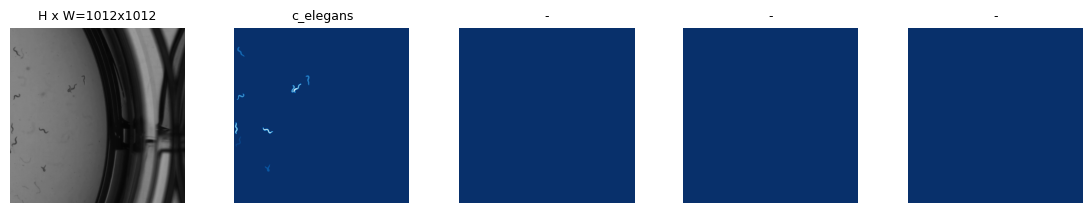

In [91]:
from mrcnn import visualize
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 1)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [92]:
def double_conv_block(x, n_filters):
       # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [93]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [94]:
def upsample_block(x, conv_features, n_filters):
    # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [95]:
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [96]:
# Erstelle das U-Net Modell
model = unet_model()

In [97]:
# Compile the U-Net model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras"""
    def __init__(self, dataset, config, batch_size=1, image_size=(256, 256), shuffle=True):
        self.dataset = dataset
        self.config = config
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.image_ids = np.copy(self.dataset.image_ids)
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        batch_image_ids = [self.image_ids[k] for k in indexes]

        # Generate data
        images, masks = self.__data_generation(batch_image_ids)
        
        print("Images shape:", images.shape)
        print("Masks shape:", masks.shape)


        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_ids):
        """Generates data containing batch_size samples"""
        images = []
        masks = []

        # Generate data
        for image_id in batch_image_ids:
            # Load image and resize to the required shape
            image = self.dataset.load_image(image_id)
            image = tf.convert_to_tensor(image, dtype=tf.float32)  # Ensure it's a Tensor
            image = tf.image.resize(image, self.image_size)

            # Load mask and resize to the required shape
            mask, _ = self.dataset.load_mask(image_id)
            mask = tf.convert_to_tensor(mask, dtype=tf.float32)  # Ensure it's a Tensor
            mask = tf.image.resize(mask, self.image_size)

            # Ensure the mask has a single channel (grayscale)
            if mask.shape[-1] != 1:
                mask = tf.reduce_max(mask, axis=-1, keepdims=True)  # Convert multi-class mask to binary

            images.append(image)
            masks.append(mask)

        return tf.stack(images), tf.stack(masks)  # Ensure we return TensorFlow Tensors

In [99]:
from cElegans import CElegansConfig
config = CElegansConfig()

In [100]:
train_generator = DataGenerator(dataset, config, batch_size=2, image_size=(256, 256), shuffle=True)
val_generator = DataGenerator(dataset_val, config, batch_size=2, image_size=(256, 256), shuffle=True)

In [101]:
print(model.input_shape)


(None, 256, 256, 3)


In [102]:
# Train the model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


2024-09-09 16:23:14.251055: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_transpose_1/bias/Assign' id:254 op device:{requested: '', assigned: ''} def:{{{node conv2d_transpose_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_transpose_1/bias, conv2d_transpose_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)


2024-09-09 16:23:16.079665: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/conv2d/kernel/v/Assign' id:799 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d/kernel/v, training/Adam/conv2d/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


InvalidArgumentError: Requested tensor connection from unknown node: "input_1:0".

Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)


In [103]:
import tensorflow as tf
print(tf.__version__)


2.13.0


In [ ]:
import tensorflow.keras.backend as K
K.clear_session()


In [104]:
import tensorflow.keras.backend as K
K.clear_session()

# Rebuild the U-Net model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [105]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,   # Start with 1 epoch for testing
    verbose=2   # More detailed output
)

2024-09-09 16:24:30.524067: W tensorflow/c/c_api.cc:304] Operation '{name:'count/Assign' id:356 op device:{requested: '', assigned: ''} def:{{{node count/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count, count/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)


2024-09-09 16:24:31.791501: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/conv2d_transpose_1/kernel/v/Assign' id:907 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_transpose_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_transpose_1/kernel/v, training/Adam/conv2d_transpose_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


InvalidArgumentError: Requested tensor connection from unknown node: "input_1:0".

Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)
Images shape: (2, 256, 256, 3)
Masks shape: (2, 256, 256, 1)


In [107]:
train_iter = iter(train_generator)

# Fetch the next batch from the iterator
images, masks = next(train_iter)

# Now you can manually train on this small batch
model.fit(images, masks, epochs=1)

RuntimeError: generator raised StopIteration